In [1]:
import numpy as np
import pandas as pd
import matplotlib
print(matplotlib.__version__)
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
from glob import glob
from collections import Counter
import re, os
import ns
import ns_hdf5
import history_cmc as hic
import math
import scipy
from scipy.interpolate import interp1d
from scipy import stats
import matplotlib.cm as cm
import matplotlib as mpl
import random
from random import shuffle
import gzip
import sys
import astropy
from astropy import units
from scipy.optimize import bisect
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


import gw_ecc_calc as gwcalc
import unit_convert as uc
import merger_rate_calculator as mr
import ns_tidalcapture as tc
import conversions
import dynamics as dyn
import scripts3
import scripts2
import scripts1
import scripts
import LISA_calculations as lisa_calc
import extract_full_hist as ehist
import psr_catalog as pc


sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')
import cmctoolkit as cmct

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams.update({'font.size': 22})
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
      
twopi=2.*np.pi
yearsc=3.1557*10**7
Kconst=9.87*10**-48 ##yr/G^2
Gconst=6.674*10**-8 ##cm3*g-1*s-2
Gconst_sun = 4.30091*10**-3 ##pc*M_sun**-1*(km/s)2
clight=3*10**10 ##cm/s
Msun=2*10**33 ##gram
Rsun=6.957e+10 ##cm
AU=1.496*10**13  ##cm
AU_Rsun=214.93946938362 ##AU to R_sun
PC=3.086*10**18  ##cm
PC_Rsun = 44334448.0068964 ##pc to R_sun

savepath = '/projects/b1095/syr904/projects/halo_NSWD/plots/'

2.1.2


In [2]:
sourcedir = np.genfromtxt('/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allpaths.dat',
                         dtype=str)
model_label = sourcedir[:,0]; paths = sourcedir[:,1]
#model_label = ['Fiducial', 'TDE0.2', 'TDE0.8', 'WDTC', 'TDE0.2-WDTC', 'TDE0.2-WDTC-GCTC', 'WDTC_NSM', 'Alloff_WM']
snap_h5 = 'initial.snapshots.h5'
ab_cut = 8

In [3]:
##Observed name and offsets
psrnames = ['PSRA','PSRB','PSRC','PSRD','PSRE','PSRF']
psroffsets = np.array([6.39, 0.1, 2.7, 0.19, 0.13, 0.082])*60. ##arcsec

psrnames_47Tuc = ['J0023-7204C','J0024-7204D','J0024-7205E','J0024-7204F','J0024-7204G','J0024-7204H',
                  'J0024-7204I','J0023-7203J','J0024-7204L','J0023-7205M','J0024-7204N','J0024-7204O',
                  'J0024-7204Q','J0024-7204R','J0024-7204S','J0024-7204T','J0024-7203U',
                  'J0024-7204W','J0024-7201X','J0024-7204Y','J0024-7204Z','J0024-7204aa',
                  'J0024-7204ab']
psroffsets_47Tuc = np.array([1.21,0.68,0.65,0.19,0.29,0.77,0.29,1,0.14,1.05,0.49,0.06,
                       0.98,0.15,0.19,0.34,0.94,0.08,3.83,0.37,0.15,0.47,0.2])*60. ##arcsec

11054.52569672
476
11247.982754360002
479
11492.75262108
482
11678.87079372
485
11984.68128812
488
12200.5200892
491
12415.368900000001
494
12684.630060000001
497
13021.5236848
500
13194.21794016
503
13474.520157400002
506
13703.84361136
509
13800.02855656
512
2724.6605835248265
0.08791208791208792
0.11805555555555555
0.17312435356830297
msp [ 104900   26633  104900  104900  104900  331891  352346  104900 1153004
  331891  331891  331891  331891 1534911  331891  331891] [1247733    -100 1247733    -100    -100    -100   89217    -100 1376095
    -100    -100    -100    -100  282110    -100    -100] [11054.52569672 11247.98275436 11247.98275436 11492.75262108
 11678.87079372 11984.68128812 11984.68128812 11984.68128812
 12415.3689     12684.63006    13021.5236848  13194.21794016
 13474.5201574  13474.5201574  13703.84361136 13800.02855656]
msp [476 479 479 482 485 488 488 488 494 497 500 503 506 506 509 512]
nsbin [ 825478  104900  806753  337739  825478 1074229  449166  436793  104900


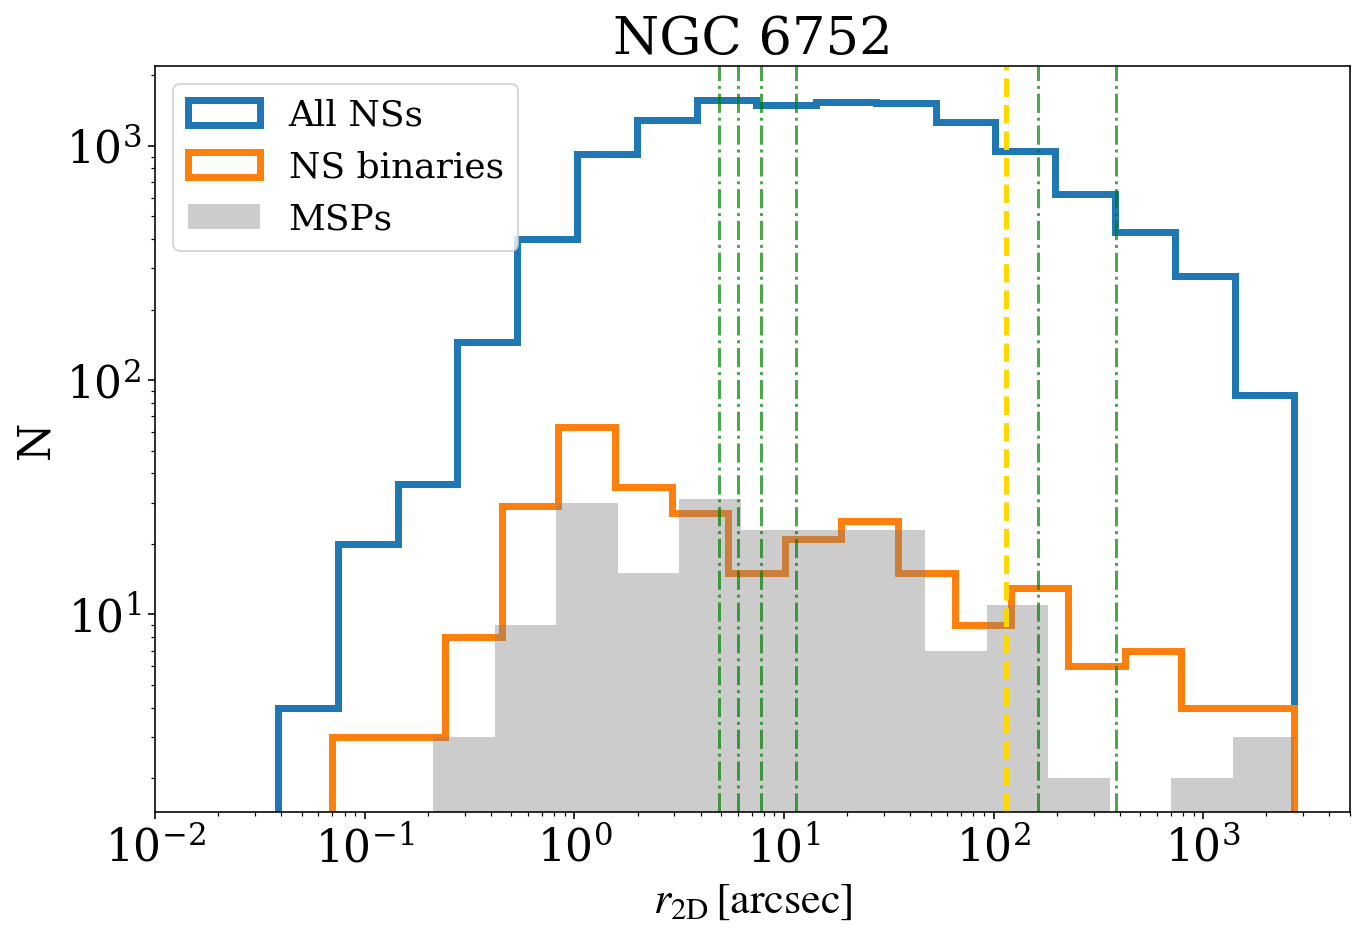

In [4]:
# All single NS and NS-WD Offset Distributions in 6752
##Fiducial model
d6752 = 4.125 ##kpc

#snapno=488 ##12 Gyr

##Cumulative radial distribution
path_6752 = paths[0]#'/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/'

snap2d = np.sort(glob(path_6752+'initial.snap*.2Dproj.dat.gz'))
clus_param = np.sort(glob(path_6752+'initial.snap*.cluster_params.dat'))

#snap2d_unsort=np.array(glob(path_6752+'*.snap*.2Dproj.dat.gz'))
#clus_param_unsort=np.array(glob(path_6752+'initial.snap*.cluster_params.dat'))
#snap2dno_unsort = [int((x.split('.')[-4]).split('p')[1]) for x in snap2d_unsort]
#snap2dno, snap2d = zip(*sorted(zip(snap2dno_unsort,snap2d_unsort)))
#       
#clusno_unsort=[int((x.split('.')[-3]).split('p')[1]) for x in clus_param_unsort]
#clusno, clus_param = zip(*sorted(zip(clusno_unsort,clus_param_unsort)))
#print(snap2dno, snap2d)
    
rpc = []; m_tot = []; rpc_msp = []; mtot_msp = []; mtot_nonmsp = []
rpc_nsbin = []
id_2dmsp = []; idcomp_2dmsp = []; t_2dmsp = []; snapno_2dmsp = []
id_2dbin = []; idcomp_2dbin = []; t_2dbin = []; snapno_2dbin = []
n_nonmsp_sin = 0; n_msp_sin = 0
for yy in range(len(clus_param)):
    data_param = np.genfromtxt(clus_param[yy])
    if os.stat(clus_param[yy]).st_size==0:
        continue
    if data_param[0][0]<11000.: continue
    if data_param[0][0]>14000.: break
        
    print(data_param[0][0])
    thesnapno = int(snap2d[yy].split('.')[-4][4:])
    print(thesnapno)
        
    ##First make the MSP files
    #ns_hdf5.get_allpsr_atsnap(path_6752, 'MSP', thesnapno, 4.125, 0.0002)
        
    ##Now extract data from multiple snapshots
    datamsp = np.genfromtxt(path_6752+'MSP'+str(thesnapno)+'.dat')
    id_msp = datamsp[:,10]; sn_msp = datamsp[:,16]; tc_msp = datamsp[:,17]
    
    with gzip.open(path_6752+'initial.snap'+str(thesnapno)+'.2Dproj.dat.gz', 'r') as f2d:
            next(f2d); next(f2d)
            for line in f2d:
                data2d = line.split()
                if int(data2d[2]) == 1:
                    if int(data2d[5]) == 13 or int(data2d[6]) == 13: 
                        rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                        rpc_nsbin.append(float(data2d[0]))
                        if int(data2d[5]) == 13:
                            id_2dbin.append(int(float(data2d[13])))
                            idcomp_2dbin.append(int(float(data2d[14])))
                            t_2dbin.append(data_param[0][0])
                            snapno_2dbin.append(thesnapno)
                        elif int(data2d[6]) == 13: 
                            id_2dbin.append(int(float(data2d[14])))
                            idcomp_2dbin.append(int(float(data2d[13])))
                            t_2dbin.append(data_param[0][0])
                            snapno_2dbin.append(thesnapno)
                            
                        if float(data2d[13]) in id_msp or float(data2d[14]) in id_msp:
                            rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                            if float(data2d[13]) in id_msp:
                                id_2dmsp.append(int(float(data2d[13])))
                                idcomp_2dmsp.append(int(float(data2d[14])))
                                t_2dmsp.append(data_param[0][0])
                                snapno_2dmsp.append(thesnapno)
                            if float(data2d[14]) in id_msp:
                                id_2dmsp.append(int(float(data2d[14])))
                                idcomp_2dmsp.append(int(float(data2d[13])))
                                t_2dmsp.append(data_param[0][0])
                                snapno_2dmsp.append(thesnapno)
                        else:
                            mtot_nonmsp.append(float(data2d[9]))
                            
                else:
                    if int(data2d[3]) == 13: 
                        rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                        if float(data2d[12]) in id_msp:
                            rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                            id_2dmsp.append(int(float(data2d[12])))
                            idcomp_2dmsp.append(-100)
                            t_2dmsp.append(data_param[0][0])
                            snapno_2dmsp.append(thesnapno)
                            n_msp_sin+=1
                        else:
                            mtot_nonmsp.append(float(data2d[9]))
                            n_nonmsp_sin+=1
                        
r_proj = np.array(rpc)/(d6752*1000.)*180/np.pi*60*60
r_proj_msp = np.array(rpc_msp)/(d6752*1000.)*180/np.pi*60*60
r_proj_nsbin = np.array(rpc_nsbin)/(d6752*1000.)*180/np.pi*60*60
    
    #print(np.mean(m_tot), np.mean(mtot_msp), np.mean(mtot_nonmsp))
    #print(np.median(m_tot), np.median(mtot_msp), np.median(mtot_nonmsp))
    #print(len(m_tot), len(mtot_msp), len(mtot_nonmsp))
    #print(n_msp_sin, n_nonmsp_sin)

print(np.max(r_proj))

print(len(r_proj_msp[r_proj_msp>1.91*60.])/len(r_proj_msp))
print(len(r_proj_nsbin[r_proj_nsbin>1.91*60.])/len(r_proj_nsbin))
print(len(r_proj[r_proj>1.91*60.])/len(r_proj))

##Now make the plot by stacking multiple snapshots
fig, axs = plt.subplots(figsize = (10, 7))
axs.hist(r_proj, bins = np.logspace(np.log10(min(r_proj)), np.log10(np.max(r_proj)), 18), 
         cumulative = False, density = False, #weights = np.ones_like(r_proj) / float(len(r_proj)),
         histtype = 'step', lw = 3.5, label = 'All NSs')
axs.hist(r_proj_nsbin, bins = np.logspace(np.log10(min(r_proj_nsbin)), np.log10(np.max(r_proj)), 18), 
         cumulative = False, density = False, #weights = np.ones_like(r_proj_nsbin) / float(len(r_proj_nsbin)),
         histtype = 'step', lw = 3.5, label = 'NS binaries')
axs.hist(r_proj_msp, bins = np.logspace(np.log10(min(r_proj_msp)), np.log10(np.max(r_proj)), 15), 
         cumulative = False, density = False, #weights = np.ones_like(r_proj_msp) / float(len(r_proj_msp)),
         color = 'grey', lw = 3., alpha=0.4, label = 'MSPs')
[axs.axvline(_x, lw = 1.5, color = 'green', alpha=0.7, ls='dashdot') for _x in psroffsets]
axs.axvline(x=1.91*60., lw = 2.5, color = 'gold', ls='--')
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlim(xmin = 0.01, xmax = 5000.)
#axs.set_ylim(ymin=10**-5, ymax = 1.)
axs.set_xlabel(r'$r_{\rm{2D}}\,[\rm{arcsec}]$')
axs.set_ylabel('N')
axs.legend(loc = 'upper left', fontsize = 18)
axs.set_title('NGC 6752')
fig.subplots_adjust(wspace = 0.2)
fig.tight_layout()

plt.savefig(savepath+'offsets_11to13dot5_new6752.pdf', dpi=300)
print('msp', np.array(id_2dmsp)[r_proj_msp>1.91*60.], np.array(idcomp_2dmsp)[r_proj_msp>1.91*60.],
      np.array(t_2dmsp)[r_proj_msp>1.91*60.])
print('msp', np.array(snapno_2dmsp)[r_proj_msp>1.91*60.])
print('nsbin', np.array(id_2dbin)[r_proj_nsbin>1.91*60.], np.array(idcomp_2dbin)[r_proj_nsbin>1.91*60.],
      np.array(t_2dbin)[r_proj_nsbin>1.91*60.])
print('nsbin', np.array(snapno_2dbin)[r_proj_nsbin>1.91*60.])

In [ ]:
#snap = cmct.Snapshot(fname=paths[0]+'initial.snapshots.h5', snapshot_name='/471(t=15.521915)',
#                     conv=paths[0]+'initial.conv.sh', 
#                     z=0.0002)
#
#id0 = np.array(snap.data['id0']); id1 = np.array(snap.data['id1'])
#sma = np.array(snap.data['a_AU']); ecc = np.array(snap.data['e'])
#k0 = np.array(snap.data['bin_startype0']); k1 = np.array(snap.data['bin_startype1'])
#r = np.array(snap.data['r'])
#
#print(0.5*r[(id0==1153004) | (id1==1153004)], k0[(id0==1153004) | (id1==1153004)], k1[(id0==1153004) | (id1==1153004)])


snap = cmct.Snapshot(fname=paths[0]+'initial.snapshots.h5', snapshot_name='/506(t=19.966985)',#'/505(t=19.783743)',
                     conv=paths[0]+'initial.conv.sh', 
                     z=0.0002)

id0 = np.array(snap.data['id0']); id1 = np.array(snap.data['id1'])
sma = np.array(snap.data['a_AU']); ecc = np.array(snap.data['e'])
k0 = np.array(snap.data['bin_startype0']); k1 = np.array(snap.data['bin_startype1'])
r = np.array(snap.data['r'])

print(0.5*r[(id0==1534911) | (id1==1534911)], k0[(id0==1534911) | (id1==1534911)], k1[(id0==1534911) | (id1==1534911)])

snap = cmct.Snapshot(fname=paths[0]+'initial.snapshots.h5', snapshot_name='/466(t=15.027318)',#'/505(t=19.783743)',
                     conv=paths[0]+'initial.conv.sh', 
                     z=0.0002)

id_star = np.array(snap.data['id'])
id0 = np.array(snap.data['id0']); id1 = np.array(snap.data['id1'])
sma = np.array(snap.data['a_AU']); ecc = np.array(snap.data['e'])
k0 = np.array(snap.data['bin_startype0']); k1 = np.array(snap.data['bin_startype1'])
r = np.array(snap.data['r'])

print(0.5*r[(id_star==1085042)])

[4.82196786] [10] [13]
[0.04295018]


9131.220961464
706
9271.658365928
709
9392.624490592
712
9520.431018
715
9718.22153442
718
9822.276406292
721
10024.197875384
724
10301.095562464
727
10416.954415616001
730
10549.322533848
733
10732.408762908
736
10974.265419152
739
11157.077265152
742
11399.214916096
745
11554.970608888
748
11708.552614835999
751
11882.765361852
754
3773.5781232452746
0.08523409363745499
0.05986509274873524
0.2159257029839195
msp [1660000  154126   97908 1793013   97908  154126 1793013 1660000  154126
   97908 1793013 1660000 1354220   97908  154126 1660000 1793013 1354220
 1660000   97908  154126 1793013   97908 1660000 1793013   97908  154126
 1793013 1660000   97908  154126 1660000 1793013  154126   97908 1793013
 1660000   97908 1793013 1660000  154126   97908 1793013 1660000 1354220
  154126   97908 1660000 1793013  154126 1660000   97908 1793013   97908
  154126 1793013 1660000   97908  154126 1793013 1660000  890912   97908
 1793013  154126 1660000  890912  154126   97908 1660000 1793013] [3036

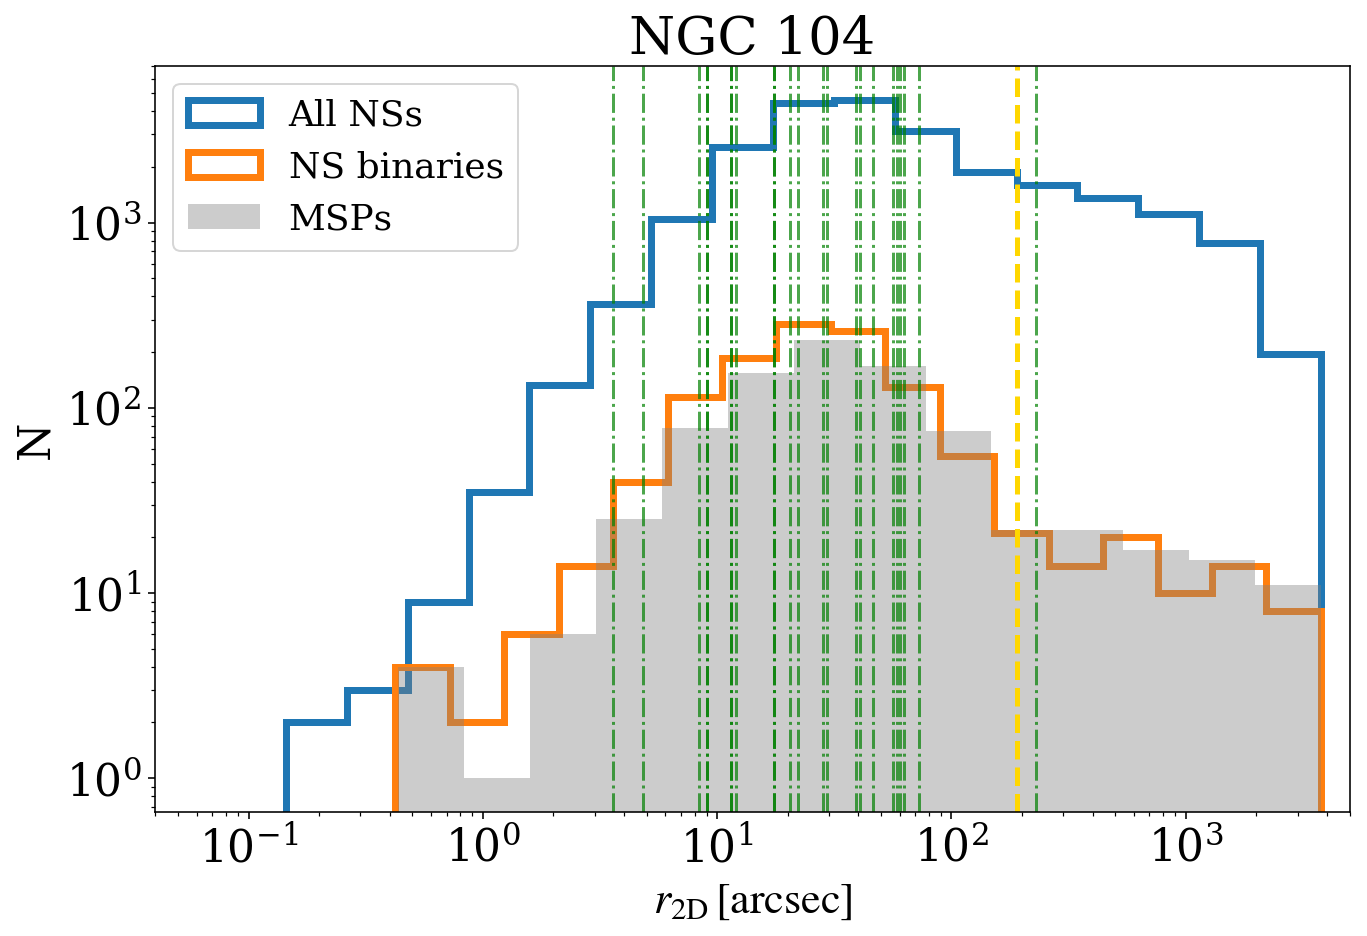

In [5]:
# All single NS and NS-WD Offset Distributions in 47 Tuc
##Fiducial model
d104 = 4.52 ##kpc
rhl104 = 3.17 ##half-light radius in arcmin

#snapno=488 ##12 Gyr

##Cumulative radial distribution
path_47 = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/observed_profiles/'
path_47_1 = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/'

snap2d = np.sort(glob(path_47+'initial.snap*.2Dproj.dat.gz'))
clus_param = np.sort(glob(path_47+'initial.snap*.cluster_params.dat'))
#print(snap2d,clus_param)   

rpc = []; m_tot = []; rpc_msp = []; mtot_msp = []; mtot_nonmsp = []
rpc_nsbin = []
id_2dmsp = []; idcomp_2dmsp = []; t_2dmsp = []; snapno_2dmsp = []
id_2dbin = []; idcomp_2dbin = []; t_2dbin = []; snapno_2dbin = []
n_nonmsp_sin = 0; n_msp_sin = 0
for yy in range(len(clus_param)):
    data_param = np.genfromtxt(clus_param[yy])
    if os.stat(clus_param[yy]).st_size==0:
        continue
    if data_param[0][0]<9000.: continue
    if data_param[0][0]>12000.: break
        
    print(data_param[0][0])
    thesnapno = int(snap2d[yy].split('.')[-4][4:])
    print(thesnapno)
        
    ##First make the MSP files
    #ns_hdf5.get_allpsr_atsnap(path_47_1, 'MSP_obs_profile', thesnapno, 4.52, 0.0038)
        
    ##Now extract data from multiple snapshots
    datamsp = np.genfromtxt(path_47_1+'MSP_obs_profile'+str(thesnapno)+'.dat')
    id_msp = datamsp[:,10]; sn_msp = datamsp[:,16]; tc_msp = datamsp[:,17]
    
    with gzip.open(path_47+'initial.snap'+str(thesnapno)+'.2Dproj.dat.gz', 'r') as f2d:
            next(f2d); next(f2d)
            for line in f2d:
                data2d = line.split()
                if int(data2d[2]) == 1:
                    if int(data2d[5]) == 13 or int(data2d[6]) == 13: 
                        rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                        rpc_nsbin.append(float(data2d[0]))
                        if int(data2d[5]) == 13:
                            id_2dbin.append(int(float(data2d[13])))
                            idcomp_2dbin.append(int(float(data2d[14])))
                            t_2dbin.append(data_param[0][0])
                            snapno_2dbin.append(thesnapno)
                        if int(data2d[6]) == 13: 
                            id_2dbin.append(int(float(data2d[14])))
                            idcomp_2dbin.append(int(float(data2d[13])))
                            t_2dbin.append(data_param[0][0])
                            snapno_2dbin.append(thesnapno)
                            
                        if float(data2d[13]) in id_msp or float(data2d[14]) in id_msp:
                            rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                            if float(data2d[13]) in id_msp:
                                id_2dmsp.append(int(float(data2d[13])))
                                idcomp_2dmsp.append(int(float(data2d[14])))
                                t_2dmsp.append(data_param[0][0])
                                snapno_2dmsp.append(thesnapno)
                            if float(data2d[14]) in id_msp:
                                id_2dmsp.append(int(float(data2d[14])))
                                idcomp_2dmsp.append(int(float(data2d[13])))
                                t_2dmsp.append(data_param[0][0])
                                snapno_2dmsp.append(thesnapno)
                        else:
                            mtot_nonmsp.append(float(data2d[9]))
                            
                else:
                    if int(data2d[3]) == 13: 
                        rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                        if float(data2d[12]) in id_msp:
                            rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                            id_2dmsp.append(int(float(data2d[12])))
                            idcomp_2dmsp.append(-100)
                            t_2dmsp.append(data_param[0][0])
                            snapno_2dmsp.append(thesnapno)
                            n_msp_sin+=1
                        else:
                            mtot_nonmsp.append(float(data2d[9]))
                            n_nonmsp_sin+=1
                        
r_proj = np.array(rpc)/(d104*1000.)*180/np.pi*60*60
r_proj_msp = np.array(rpc_msp)/(d104*1000.)*180/np.pi*60*60
r_proj_nsbin = np.array(rpc_nsbin)/(d104*1000.)*180/np.pi*60*60
    
    #print(np.mean(m_tot), np.mean(mtot_msp), np.mean(mtot_nonmsp))
    #print(np.median(m_tot), np.median(mtot_msp), np.median(mtot_nonmsp))
    #print(len(m_tot), len(mtot_msp), len(mtot_nonmsp))
    #print(n_msp_sin, n_nonmsp_sin)

print(np.max(r_proj))

print(len(r_proj_msp[r_proj_msp>rhl104*60.])/len(r_proj_msp))
print(len(r_proj_nsbin[r_proj_nsbin>rhl104*60.])/len(r_proj_nsbin))
print(len(r_proj[r_proj>rhl104*60.])/len(r_proj))

##Now make the plot by stacking multiple snapshots
fig, axs = plt.subplots(figsize = (10, 7))
axs.hist(r_proj, bins = np.logspace(np.log10(min(r_proj)), np.log10(np.max(r_proj)), 18), 
         cumulative = False, density = False, #weights = np.ones_like(r_proj) / float(len(r_proj)),
         histtype = 'step', lw = 3.5, label = 'All NSs')
axs.hist(r_proj_nsbin, bins = np.logspace(np.log10(min(r_proj_nsbin)), np.log10(np.max(r_proj)), 18), 
         cumulative = False, density = False, #weights = np.ones_like(r_proj_nsbin) / float(len(r_proj_nsbin)),
         histtype = 'step', lw = 3.5, label = 'NS binaries')
axs.hist(r_proj_msp, bins = np.logspace(np.log10(min(r_proj_msp)), np.log10(np.max(r_proj)), 15), 
         cumulative = False, density = False, #weights = np.ones_like(r_proj_msp) / float(len(r_proj_msp)),
         color = 'grey', lw = 3., alpha=0.4, label = 'MSPs')
[axs.axvline(_x, lw = 1.5, color = 'green', alpha=0.7, ls='dashdot') for _x in psroffsets_47Tuc]
axs.axvline(x=rhl104*60., lw = 2.5, color = 'gold', ls='--')
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlim(xmin = 0.04, xmax = 5000.)
#axs.set_ylim(ymin=10**-5, ymax = 1.)
axs.set_xlabel(r'$r_{\rm{2D}}\,[\rm{arcsec}]$')
axs.set_ylabel('N')
axs.legend(loc = 'upper left', fontsize = 18)
axs.set_title('NGC 104')
fig.subplots_adjust(wspace = 0.2)
fig.tight_layout()

plt.savefig(savepath+'offsets_9to12_47tuc.pdf', dpi=300)
print('msp', np.array(id_2dmsp)[r_proj_msp>rhl104*60.], np.array(idcomp_2dmsp)[r_proj_msp>rhl104*60.],
      np.array(t_2dmsp)[r_proj_msp>rhl104*60.])
print('msp', np.array(snapno_2dmsp)[r_proj_msp>rhl104*60.])
print('nsbin', np.array(id_2dbin)[r_proj_nsbin>rhl104*60.], np.array(idcomp_2dbin)[r_proj_nsbin>rhl104*60.],
      np.array(t_2dbin)[r_proj_nsbin>rhl104*60.])
print('nsbin', np.array(snapno_2dbin)[r_proj_nsbin>rhl104*60.])

In [ ]:
##Check the orbital eccentricity of a binary in a cluster
l_conv = 0.5  ##pc
tnbody_conv = 0.00757051 ##Myr

E = -0.0066695411*(l_conv/tnbody_conv)**2
J = 1.0281208*l_conv**2/tnbody_conv
M = 484844*0.4 ##just an estimate of late time mass
mu = 2.362331+0.008387

G_sun_pc_myr = Gconst_sun*(yearsc*10**6)**2/(PC/10**5)**2

ecc_bin = math.sqrt(1 + 2*E*J**2/(G_sun_pc_myr*M)**2)

print(ecc_bin)

The three furthest away MSPs are 331891, 352346, 104900<br />
104900: Last fewbody interaction (BS) at 16.3694274 (11 Gyr)<br />
        Merger with an ONe WD at 16.7245 (11.3 Gyr)<br />
        Offset mostly because of Fewbody exchange encounter with WD-WD binary<br />
352346: Last fewbody interaction (BS) at 17.590919 (11.9 Gyr)<br />
        Offset because of Fewbody exchaneg encounter with WD-WD binary<br />
331891: Last fewbody interaction (BS) at 15.0088356 (10.1 Gyr)<br />
        Offset because of accretion-induced collapse<br />

In [9]:
##Check the positions of the MSPs before and after fewbody interactions
id_far = [331891,104900,352346]
t_fewbody = [15.0088356,16.3694274,17.590919]

l_conv = dyn.conv('l', paths[0]+'initial.conv.sh')
with open(paths[0]+'initial.morepulsars.dat', 'r') as fpsr:
    next(fpsr)
    for xx in range(len(id_far)):
        r_prev = 0; t_prev = 0
        r_post = 0; t_post = 0
        for line in fpsr:
            data = line.split()
            if float(data[1])<14.:
                continue
            
            if int(data[2])==1:
                if float(data[1])<=t_fewbody[xx] and int(data[3])==int(id_far[xx]):
                    r_prev = float(data[19])*l_conv
                    t_prev = float(data[1])
                elif float(data[1])>=t_fewbody[xx] and int(data[3])==int(id_far[xx]):
                    r_post = float(data[19])*l_conv
                    t_post = float(data[1])
                    break
                    
                if float(data[1])<=t_fewbody[xx] and int(data[4])==int(id_far[xx]):
                    r_prev = float(data[19])*l_conv
                    t_prev = float(data[1])
                elif float(data[1])>=t_fewbody[xx] and int(data[4])==int(id_far[xx]):
                    r_post = float(data[19])*l_conv
                    t_post = float(data[1])
                    break
                    
            else:
                if float(data[1])<=t_fewbody[xx] and int(data[3])==int(id_far[xx]):
                    r_prev = float(data[19])*l_conv
                    t_prev = float(data[1])
                elif float(data[1])>=t_fewbody[xx] and int(data[3])==int(id_far[xx]):
                    r_post = float(data[19])*l_conv
                    t_post = float(data[1])
                    break
        print(id_far[xx], t_fewbody[xx], t_prev, r_prev, t_post, r_post)
        

331891 15.0088356 0 0 15.027318 0.0339592525
104900 16.3694274 16.361096 0.0269123745 16.380958 30.0083275
352346 17.590919 17.585414 0.63198395 17.631273 4.106865


13800.0
10383.8
470
[]
[]
11054.5
476
[1306.48878331]
[1306.48878331]
11492.8
482
[]
[1794.32880179]
11984.7
488
[156.14370842]
[ 126.15655586  156.14370842 1650.34846649]
12684.6
497
[]
[221.48889907]


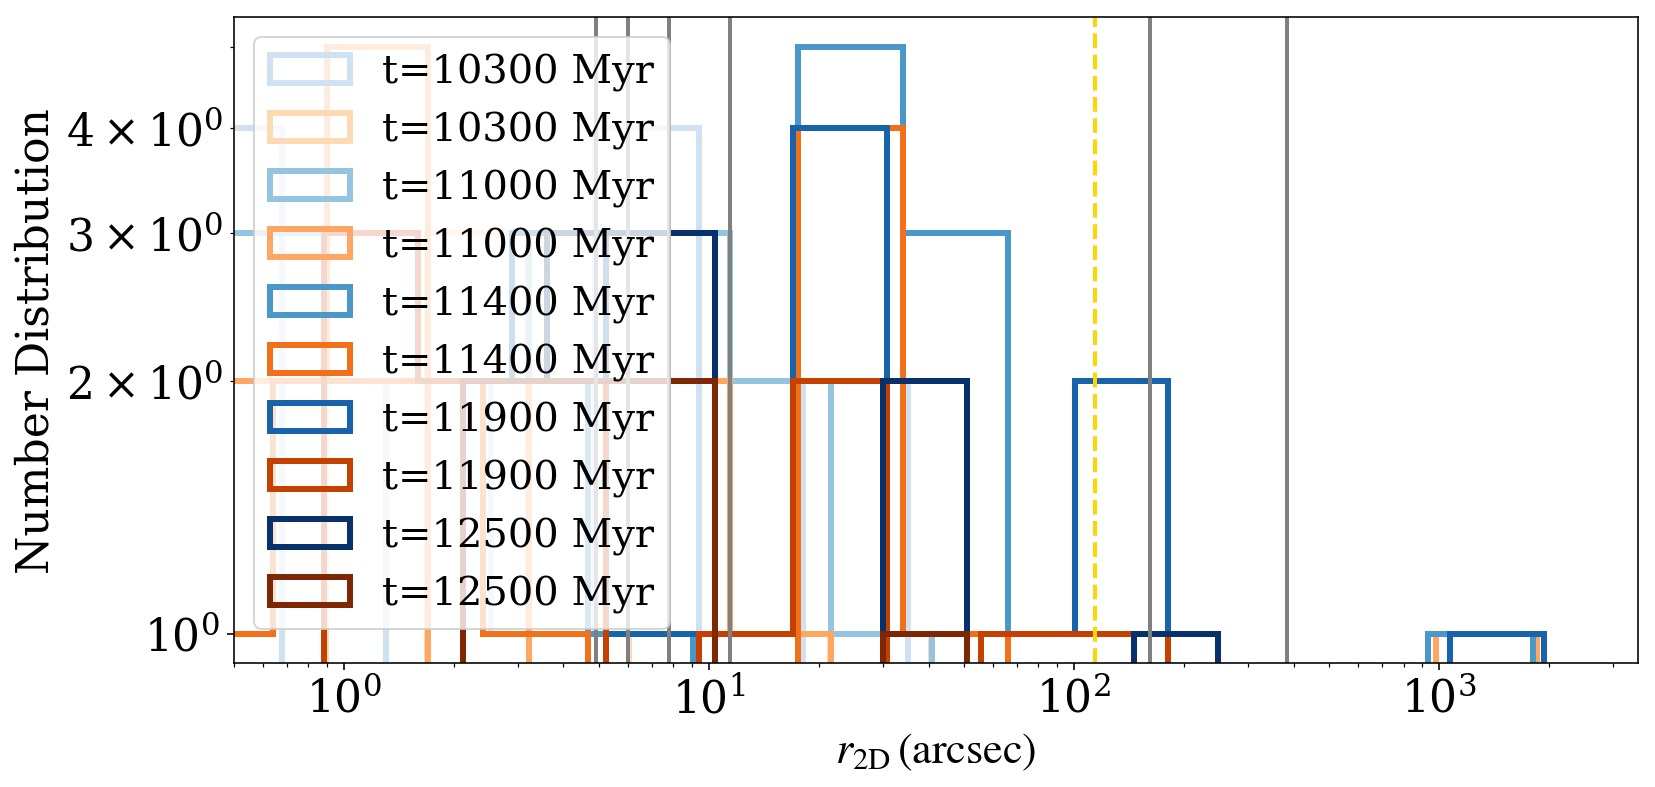

In [42]:
####All single NS and NS-WD Offset Distributions
##Comparing multiple snapshots
d6752 = 4.125 ##kpc

t_conv = dyn.conv('t', paths[0]+'initial.conv.sh')
snap2d_unsort=np.array(glob(paths[0]+'*.snap*.2Dproj.dat.gz'))
snap2dno_unsort = [int((x.split('.')[-4]).split('p')[1]) for x in snap2d_unsort]
#snap2d = snap2d_unsort[snap2dno.argsort()]
snap2dno, snap2d = zip(*sorted(zip(snap2dno_unsort,snap2d_unsort)))
print(ns.get_time(snap2d[-1]))

t_steps = [10300., 11000., 11400., 11900., 12500.]

csall = cm.Blues(np.linspace(0.2, 1, 5))
csbin = cm.Oranges(np.linspace(0.2, 1, 5))
##Cumulative radial distribution
fig, axs = plt.subplots(figsize = (12,6))
for hh in range(len(t_steps)):
    rpc = []; m_tot = []; rpc_msp = []; mtot_msp = []; mtot_nonmsp = []
    rpc_mspbin = []
    rpc_nsbin = []
    id_2dmsp = []
    n_nonmsp_sin = 0; n_msp_sin = 0
    for xx in range(len(snap2d)):
        if os.stat(snap2d[xx]).st_size==0:
            continue
        if ns.get_time(snap2d[xx])>=t_steps[hh]:
            print(ns.get_time(snap2d[xx]))

            if os.path.exists(paths[0]+'MSP'+str(snap2dno[xx])+'.dat'):
                datamsp = np.genfromtxt(paths[0]+'MSP'+str(snap2dno[xx])+'.dat')
                id_msp = datamsp[:,10]; sn_msp = datamsp[:,16]; tc_msp = datamsp[:,17]
            else:
                ns_hdf5.get_allpsr_atsnap(paths[0], 'MSP', snap2dno[xx], d6752, 0.0002)
                datamsp = np.genfromtxt(paths[0]+'MSP'+str(snap2dno[xx])+'.dat')
                id_msp = datamsp[:,10]; sn_msp = datamsp[:,16]; tc_msp = datamsp[:,17]
        
            with gzip.open(snap2d[xx], 'r') as f2d:
                    next(f2d); next(f2d)
                    for line in f2d:
                        data2d = line.split()
                        if int(data2d[2]) == 1:
                            if int(data2d[5]) == 13 or int(data2d[6]) == 13: 
                                rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                                rpc_nsbin.append(float(data2d[0]))
                                if float(data2d[13]) in id_msp or float(data2d[14]) in id_msp:
                                    rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                                    rpc_mspbin.append(float(data2d[0]))
                                    if float(data2d[13]) in id_msp:
                                        id_2dmsp.append(int(data2d[13]))
                                    if float(data2d[14]) in id_msp:
                                        id_2dmsp.append(int(float(data2d[14])))
                                else:
                                    mtot_nonmsp.append(float(data2d[9]))
                                    
                        else:
                            if int(data2d[3]) == 13: 
                                rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                                if float(data2d[12]) in id_msp:
                                    rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                                    id_2dmsp.append(int(data2d[12]))
                                    n_msp_sin+=1
                                else:
                                    mtot_nonmsp.append(float(data2d[9]))
                                    n_nonmsp_sin+=1
                                
            r_proj = np.array(rpc)/(d6752*1000.)*180/np.pi*60*60
            r_proj_msp = np.array(rpc_msp)/(d6752*1000.)*180/np.pi*60*60
            r_proj_mspbin = np.array(rpc_mspbin)/(d6752*1000.)*180/np.pi*60*60
            r_proj_nsbin = np.array(rpc_nsbin)/(d6752*1000.)*180/np.pi*60*60
            print(snap2dno[xx])
            print(r_proj_mspbin[r_proj_mspbin>=1.91*60.])
            print(r_proj_msp[r_proj_msp>=1.91*60.])
        
            #axs.hist(r_proj, bins = np.logspace(np.log10(min(r_proj)), np.log10(3500), 18), 
            #         cumulative = False, density = False, histtype = 'step', lw = 3., label = 'All NSs')
            #axs.hist(r_proj_nsbin, bins = np.logspace(np.log10(min(r_proj_nsbin)), np.log10(3500), 18), 
            #         cumulative = False, density = False, histtype = 'step', lw = 3., label = 'NS binaries')
            axs.hist(r_proj_msp, bins = np.logspace(np.log10(min(r_proj_msp)), np.log10(3500), 15), 
                     cumulative = False, density = False,
                     histtype = 'step', lw = 3., color = csall[hh], label = 't='+str(int(t_steps[hh]))+' Myr')
            axs.hist(r_proj_mspbin, bins = np.logspace(np.log10(min(r_proj_mspbin)), np.log10(3500), 15), 
                     cumulative = False, density = False, 
                     histtype = 'step', lw = 3., color = csbin[hh], label = 't='+str(int(t_steps[hh]))+' Myr')
            
            
            break

[axs.axvline(_x, lw = 2., color = 'gray', ) for _x in psroffsets]
axs.axvline(x=1.91*60., lw = 2., color = 'gold', ls='--')
axs.set_ylabel('Number Distribution')
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlim(xmin = 0.5, xmax = 3500.)
axs.set_xlabel(r'$r_{\rm{2D}}\,(\rm{arcsec})$')
axs.legend(loc = 'upper left', fontsize = 20)
fig.subplots_adjust(wspace = 0.2)
fig.tight_layout()


(2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59, 62, 65, 68, 71, 74, 77, 80, 83, 86, 89, 92, 95, 98, 101, 104, 107, 110, 113, 116, 119, 122, 125, 128, 131, 134, 137, 140, 143, 146, 149, 152, 155, 158, 161, 164, 167, 170, 173, 176, 179, 182, 185, 188, 191, 194, 197, 200, 203, 206, 209, 212, 215, 218, 221, 224, 227, 230, 233, 236, 239, 242, 245, 248, 251, 254, 257, 260, 263, 266, 269, 272, 275, 278, 281, 284, 287, 290, 293, 296, 299, 302, 305, 308, 311, 314, 317, 320, 323, 326, 329, 332, 335, 338, 341, 344, 347, 350, 353, 356, 359, 362, 365, 368, 371, 374, 377, 380, 383, 386, 389, 392, 395, 398, 401, 404, 407, 410, 413, 416, 419, 422, 425, 428, 431, 434, 437, 440, 443, 446, 449, 452, 455, 458, 461, 464, 467, 470, 473, 476, 479, 482, 485, 488, 491, 494, 497, 500, 503, 506, 509, 512)
13800.0
104.712
1024.41
5200.38
7886.29
10001.9


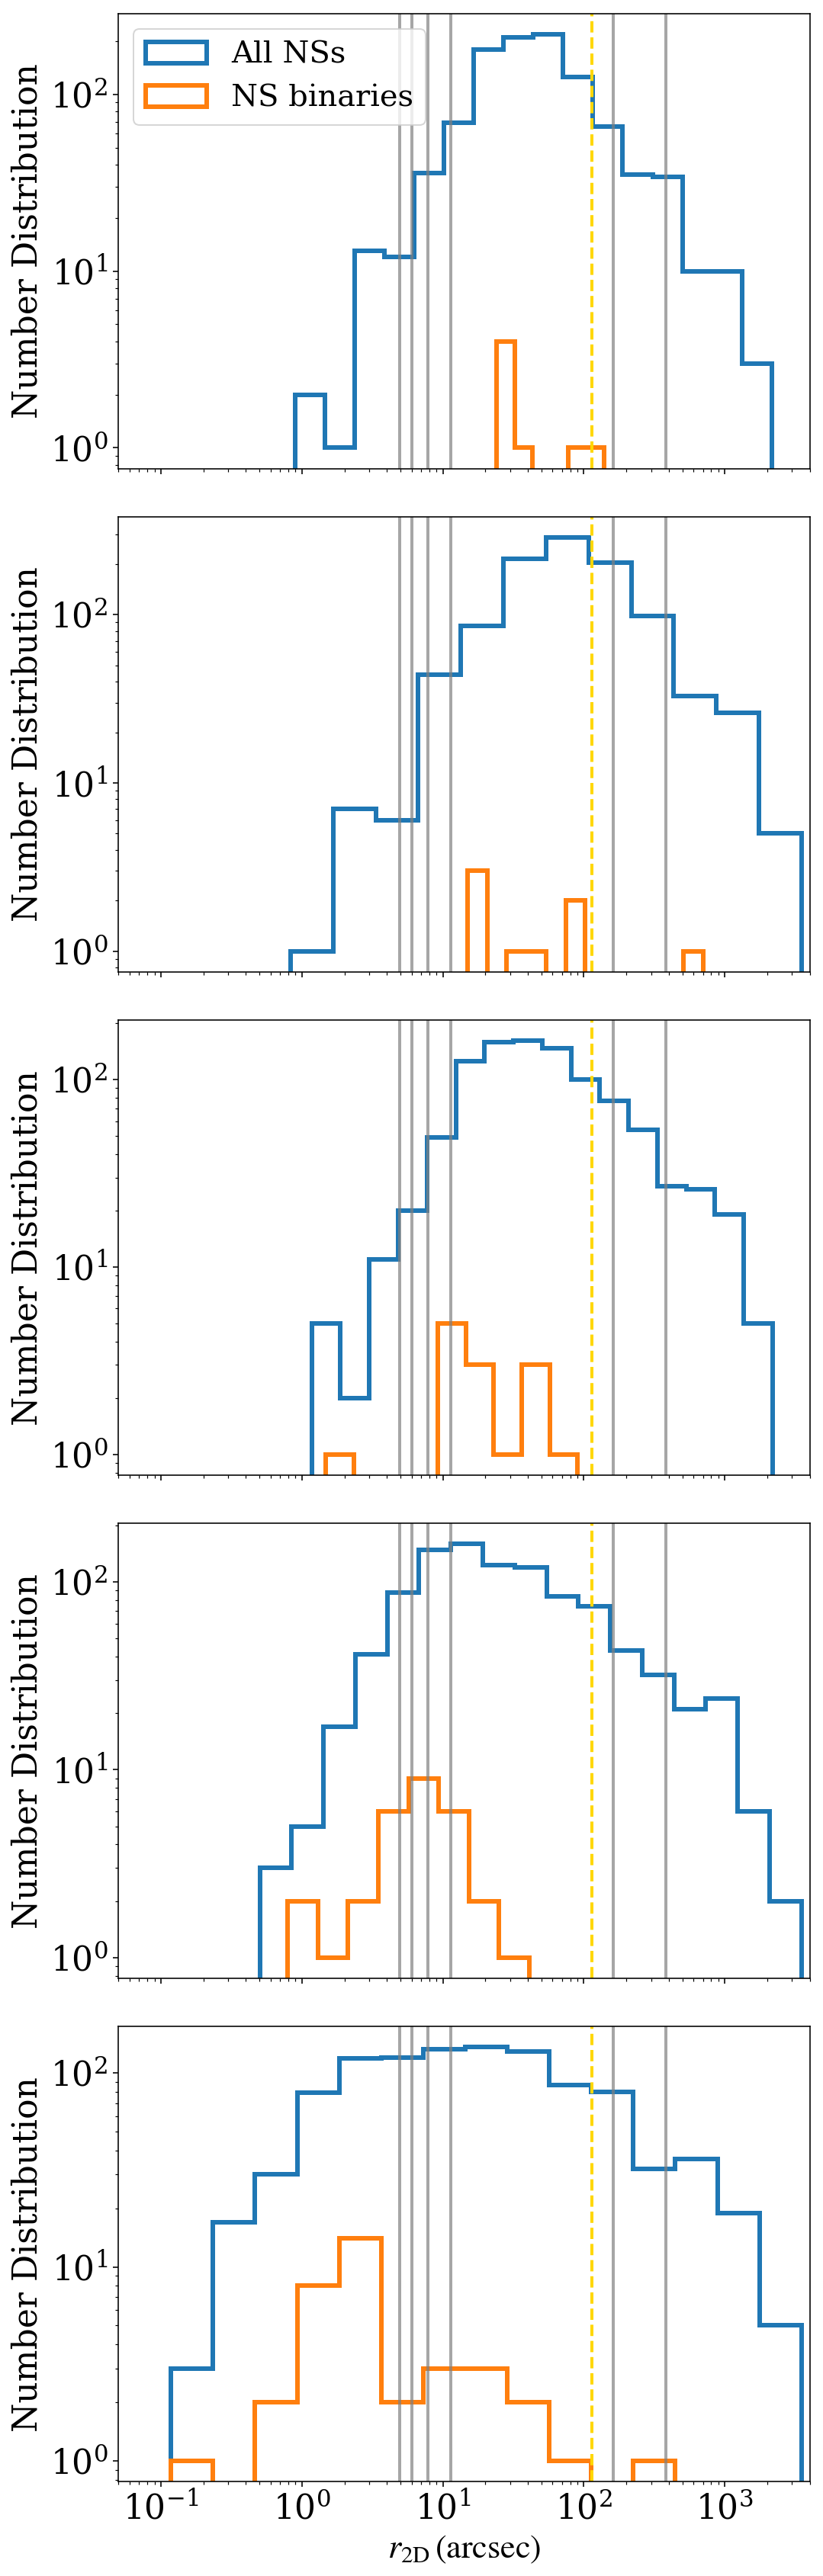

In [6]:
##Radial distribution of MSPs and NS binaries as a function of time
d6752 = 4.125 ##kpc

t_steps = [100., 1000., 5000., 7500., 10000.]

t_conv = dyn.conv('t', paths[0]+'initial.conv.sh')
snap2d_unsort=np.array(glob(paths[0]+'*.snap*.2Dproj.dat.gz'))
snap2dno_unsort = [int((x.split('.')[-4]).split('p')[1]) for x in snap2d_unsort]
#snap2d = snap2d_unsort[snap2dno.argsort()]
snap2dno, snap2d = zip(*sorted(zip(snap2dno_unsort,snap2d_unsort)))
print(snap2dno)
#print(snap2d)
print(ns.get_time(snap2d[-1]))
    
fig, axs = plt.subplots(nrows = 5, figsize=(8, 24), sharex=True)
for hh in range(len(t_steps)):
    rpc = []; m_tot = []; rpc_msp = []; mtot_msp = []; mtot_nonmsp = []
    rpc_nsbin = []
    id_2dmsp = []
    n_nonmsp_sin = 0; n_msp_sin = 0
    for xx in range(len(snap2d)):
        if os.stat(snap2d[xx]).st_size==0:
            continue
        if ns.get_time(snap2d[xx])>=t_steps[hh]:
            print(ns.get_time(snap2d[xx]))
        
            with gzip.open(snap2d[xx], 'r') as f2d:
                    next(f2d); next(f2d)
                    for line in f2d:
                        data2d = line.split()
                        if int(data2d[2]) == 1:
                            if int(data2d[5]) == 13 or int(data2d[6]) == 13: 
                                rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                                rpc_nsbin.append(float(data2d[0]))
                                #if float(data2d[13]) in id_msp or float(data2d[14]) in id_msp:
                                    #rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                                    #if float(data2d[13]) in id_msp:
                                    #    id_2dmsp.append(int(data2d[13]))
                                    #if float(data2d[14]) in id_msp:
                                    #    id_2dmsp.append(int(data2d[14]))
                                #else:
                                    #mtot_nonmsp.append(float(data2d[9]))
                                    
                        else:
                            if int(data2d[3]) == 13: 
                                rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                                #if float(data2d[12]) in id_msp:
                                #    rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                                #    id_2dmsp.append(int(data2d[12]))
                                #    n_msp_sin+=1
                                #else:
                                #    mtot_nonmsp.append(float(data2d[9]))
                                #    n_nonmsp_sin+=1
                                
            r_proj = np.array(rpc)/(d6752*1000.)*180/np.pi*60*60
            #r_proj_msp = np.array(rpc_msp)/(d6752*1000.)*180/np.pi*60*60
            r_proj_nsbin = np.array(rpc_nsbin)/(d6752*1000.)*180/np.pi*60*60
            
            
            axs[hh].hist(r_proj, bins = np.logspace(np.log10(min(r_proj)), np.log10(3500), 18), 
                     cumulative = False, density = False, histtype = 'step', lw = 3., label = 'All NSs')
            axs[hh].hist(r_proj_nsbin, bins = np.logspace(np.log10(min(r_proj_nsbin)), np.log10(3500), 18), 
                     cumulative = False, density = False, histtype = 'step', lw = 3., label = 'NS binaries')
            #axs.hist(r_proj_msp, bins = np.logspace(np.log10(min(r_proj_msp)), np.log10(3500), 15), 
            #         cumulative = False, density = False, histtype = 'step', lw = 3., label = 'MSPs')
            [axs[hh].axvline(_x, lw = 2., color = 'gray', alpha=0.7) for _x in psroffsets]
            axs[hh].axvline(x=1.91*60., lw = 2., color = 'gold', ls='--')
            axs[hh].set_xscale('log')
            axs[hh].set_yscale('log')
            axs[hh].set_xlim(xmin = 0.05, xmax = 4000.)
            axs[hh].set_ylabel('Number Distribution')
            #axs[hh].text(0.05, 10, 't='+str(int(t_steps[hh]))+' Myr', fontsize=20)
            break

            
axs[-1].set_xlabel(r'$r_{\rm{2D}}\,(\rm{arcsec})$')
axs[0].legend(loc = 'upper left', fontsize = 20)
fig.subplots_adjust(wspace = 0.05)
fig.tight_layout()

(161, 326, 501, 503, 505, 507, 509, 511, 513, 515, 517, 519, 521, 522, 523, 525, 527, 529, 531, 533, 535, 537, 539, 541, 543, 545, 547, 549, 551, 553, 555, 557, 559, 561, 563, 565, 567, 569, 571, 573, 575, 577, 579, 581, 583, 585, 587, 589, 591, 593, 595, 597, 599, 601, 603, 605, 607, 609)
13477.9
100.495
952 1
11952.9
779 13
(34, 152, 358, 360, 361, 362, 364, 366, 368, 370, 371, 372, 374, 376, 378, 380, 381, 382, 384, 386, 388, 390, 391, 392, 394, 396)
14000.0
100.263
869 1
11913.1
774 2
(9, 99, 270, 272, 274, 276, 278, 279, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310)
14000.1
102.032
576 1
12130.1
494 2


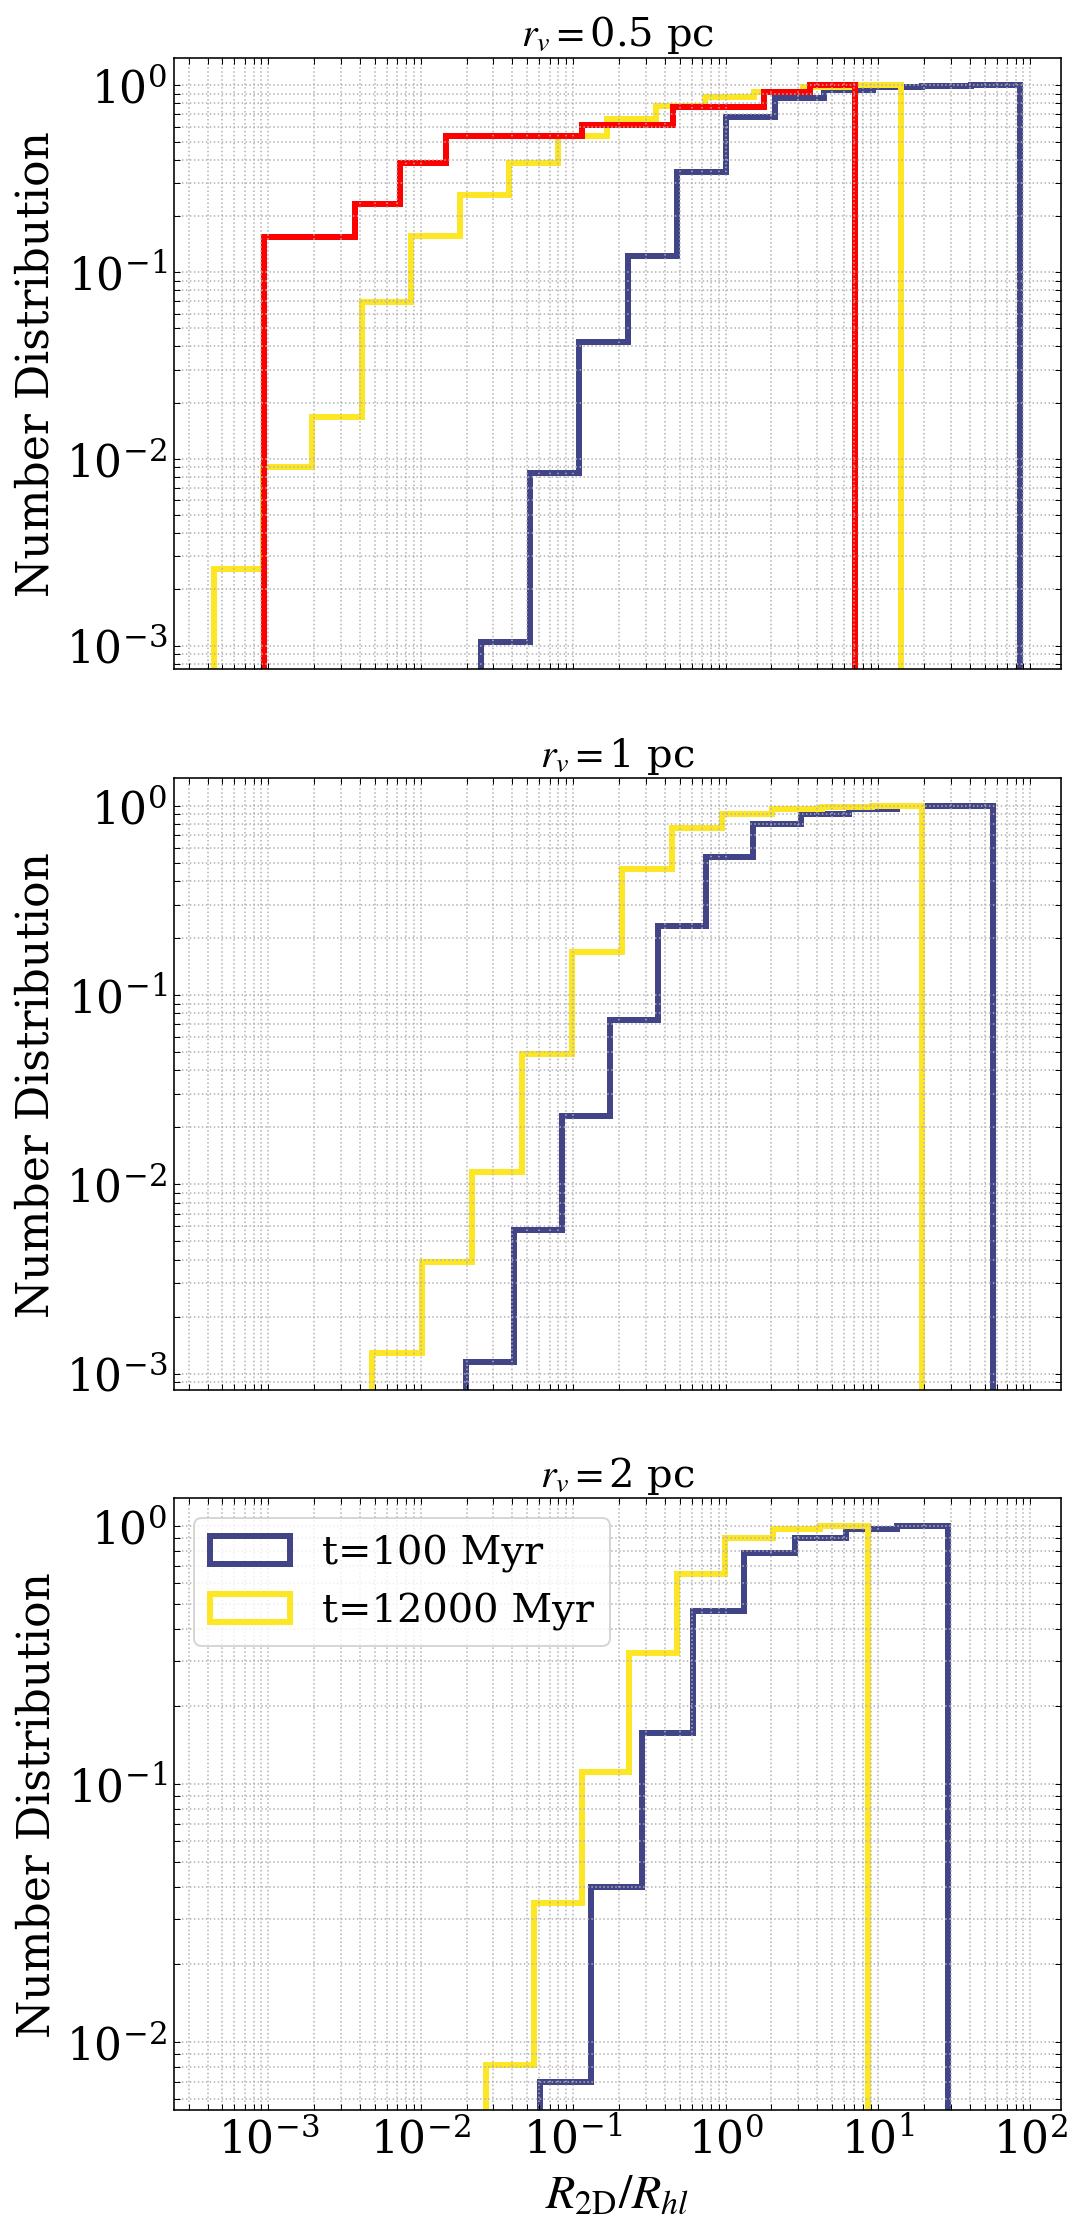

In [10]:
##Radial distribution of MSPs and NS binaries as a function of time
##Comparing CC and Noncc cluster
d6752 = 4.125 ##kpc

path2 = ['/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/', 
         '/projects/b1091/CMC_Grid_March2019/rundir/rv1/rg8/z0.0002/8e5/',
         '/projects/b1091/CMC_Grid_March2019/rundir/rv2/rg8/z0.0002/8e5/']
         #['/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg20/z0.002/8e5/',
         #'/projects/b1091/CMC_Grid_March2019/rundir/rv1/rg20/z0.002/8e5/',
         #'/projects/b1091/CMC_Grid_March2019/rundir/rv2/rg20/z0.002/8e5/']]

t_steps = [100., 11900.]
t_labels = [100., 12000.]
cs1 =  cm.viridis(np.linspace(0.2, 1, 2))
cs2 =  cm.autumn(np.linspace(0.2, 1, 2))
bin_sizes = [[12,15], [12,12], [9,9]]

rvs = [0.5, 1, 2]

fig, axs = plt.subplots(nrows = 3, figsize=(8, 16), sharex=True)
for ii in range(len(path2)):
    t_conv = dyn.conv('t', path2[ii]+'initial.conv.sh')
    snap2d_unsort=np.array(glob(path2[ii]+'*.snap*.2Dproj.dat.gz'))
    snap2dno_unsort = [int((x.split('.')[-4]).split('p')[1]) for x in snap2d_unsort]
    #snap2d = snap2d_unsort[snap2dno.argsort()]
    snap2dno, snap2d = zip(*sorted(zip(snap2dno_unsort,snap2d_unsort)))
    print(snap2dno)
    #print(snap2d)
    print(ns.get_time(snap2d[-1]))
    
    clus_param = np.sort(glob(path2[ii]+'initial.snap*.cluster_params.dat'))
    #print(clus_param)
    
    for hh in range(len(t_steps)):
        rpc = []; m_tot = []; rpc_msp = []; mtot_msp = []; mtot_nonmsp = []
        rpc_nsbin = []
        id_2dmsp = []
        n_nonmsp_sin = 0; n_msp_sin = 0
        for xx in range(len(snap2d)):
            if os.stat(snap2d[xx]).st_size==0:
                continue
            if ns.get_time(snap2d[xx])>=t_steps[hh]:
                print(ns.get_time(snap2d[xx]))
                
                data_param = np.genfromtxt(clus_param[xx])
                r_hl = data_param[0][10]
            
                with gzip.open(snap2d[xx], 'r') as f2d:
                        next(f2d); next(f2d)
                        for line in f2d:
                            data2d = line.split()
                            if int(data2d[2]) == 1:
                                if int(data2d[5]) == 13 or int(data2d[6]) == 13: 
                                    rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                                    rpc_nsbin.append(float(data2d[0]))
                                    #if float(data2d[13]) in id_msp or float(data2d[14]) in id_msp:
                                        #rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                                        #if float(data2d[13]) in id_msp:
                                        #    id_2dmsp.append(int(data2d[13]))
                                        #if float(data2d[14]) in id_msp:
                                        #    id_2dmsp.append(int(data2d[14]))
                                    #else:
                                        #mtot_nonmsp.append(float(data2d[9]))
                                        
                            else:
                                if int(data2d[3]) == 13: 
                                    rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                                    #if float(data2d[12]) in id_msp:
                                    #    rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                                    #    id_2dmsp.append(int(data2d[12]))
                                    #    n_msp_sin+=1
                                    #else:
                                    #    mtot_nonmsp.append(float(data2d[9]))
                                    #    n_nonmsp_sin+=1
                                    
                r_proj = np.array(rpc)/r_hl#/(d6752*1000.)*180/np.pi*60*60
                #r_proj_msp = np.array(rpc_msp)/(d6752*1000.)*180/np.pi*60*60
                r_proj_nsbin = np.array(rpc_nsbin)/r_hl#/(d6752*1000.)*180/np.pi*60*60
                print(len(r_proj), len(r_proj_nsbin))
                
                axs[ii].hist(r_proj, bins = np.logspace(np.log10(np.min(r_proj)), np.log10(np.max(r_proj)), bin_sizes[ii][hh]), 
                             cumulative = True, density = True, histtype = 'step', lw = 3., 
                             label = 't='+str(int(t_labels[hh]))+' Myr',
                             color = cs1[hh])
                if len(r_proj_nsbin)>5:
                    axs[ii].hist(r_proj_nsbin, bins = np.logspace(np.log10(np.min(r_proj_nsbin)), np.log10(np.max(r_proj_nsbin)), 14), 
                                 cumulative = True, density = True, histtype = 'step', lw = 3., label = 'NS binaries',
                                 color = 'red')
                #axs.hist(r_proj_msp, bins = np.logspace(np.log10(min(r_proj_msp)), np.log10(3500), 15), 
                #         cumulative = False, density = False, histtype = 'step', lw = 3., label = 'MSPs')
                #[axs[ii].axvline(_x, lw = 2., color = 'gray', alpha=0.7) for _x in psroffsets]
                #axs[ii].axvline(x=1.91*60., lw = 2., color = 'gold', ls='--')
                axs[ii].set_xscale('log')
                axs[ii].set_yscale('log')
                #axs[ii].set_xlim(xmin = 0.005, xmax = 4000.)
                axs[ii].set_ylabel('Number Distribution')
                axs[ii].set_title(r'$r_v=$'+str(rvs[ii])+' pc', fontsize=20)
                
                axs[ii].grid(linestyle=':',which='major',linewidth='0.75')
                axs[ii].grid(linestyle=':',which='minor',linewidth='0.75')
                axs[ii].xaxis.set_ticks_position('both')
                axs[ii].yaxis.set_ticks_position('both')
                axs[ii].tick_params('both',length=3,width=0.5,which='both',direction = 'in')
                break
    

axs[-1].set_xlabel(r'$R_{\rm{2D}}/R_{hl}$', fontsize=24)
axs[2].legend(loc = 'upper left', fontsize = 20)
fig.tight_layout()
#fig.subplots_adjust(vspace = 0.01)
plt.savefig(savepath+'offset_comparison.pdf', dpi=300)

In [12]:
print(1.29/(4.125*1000.)*180/np.pi*60*60)

64.50463031727378


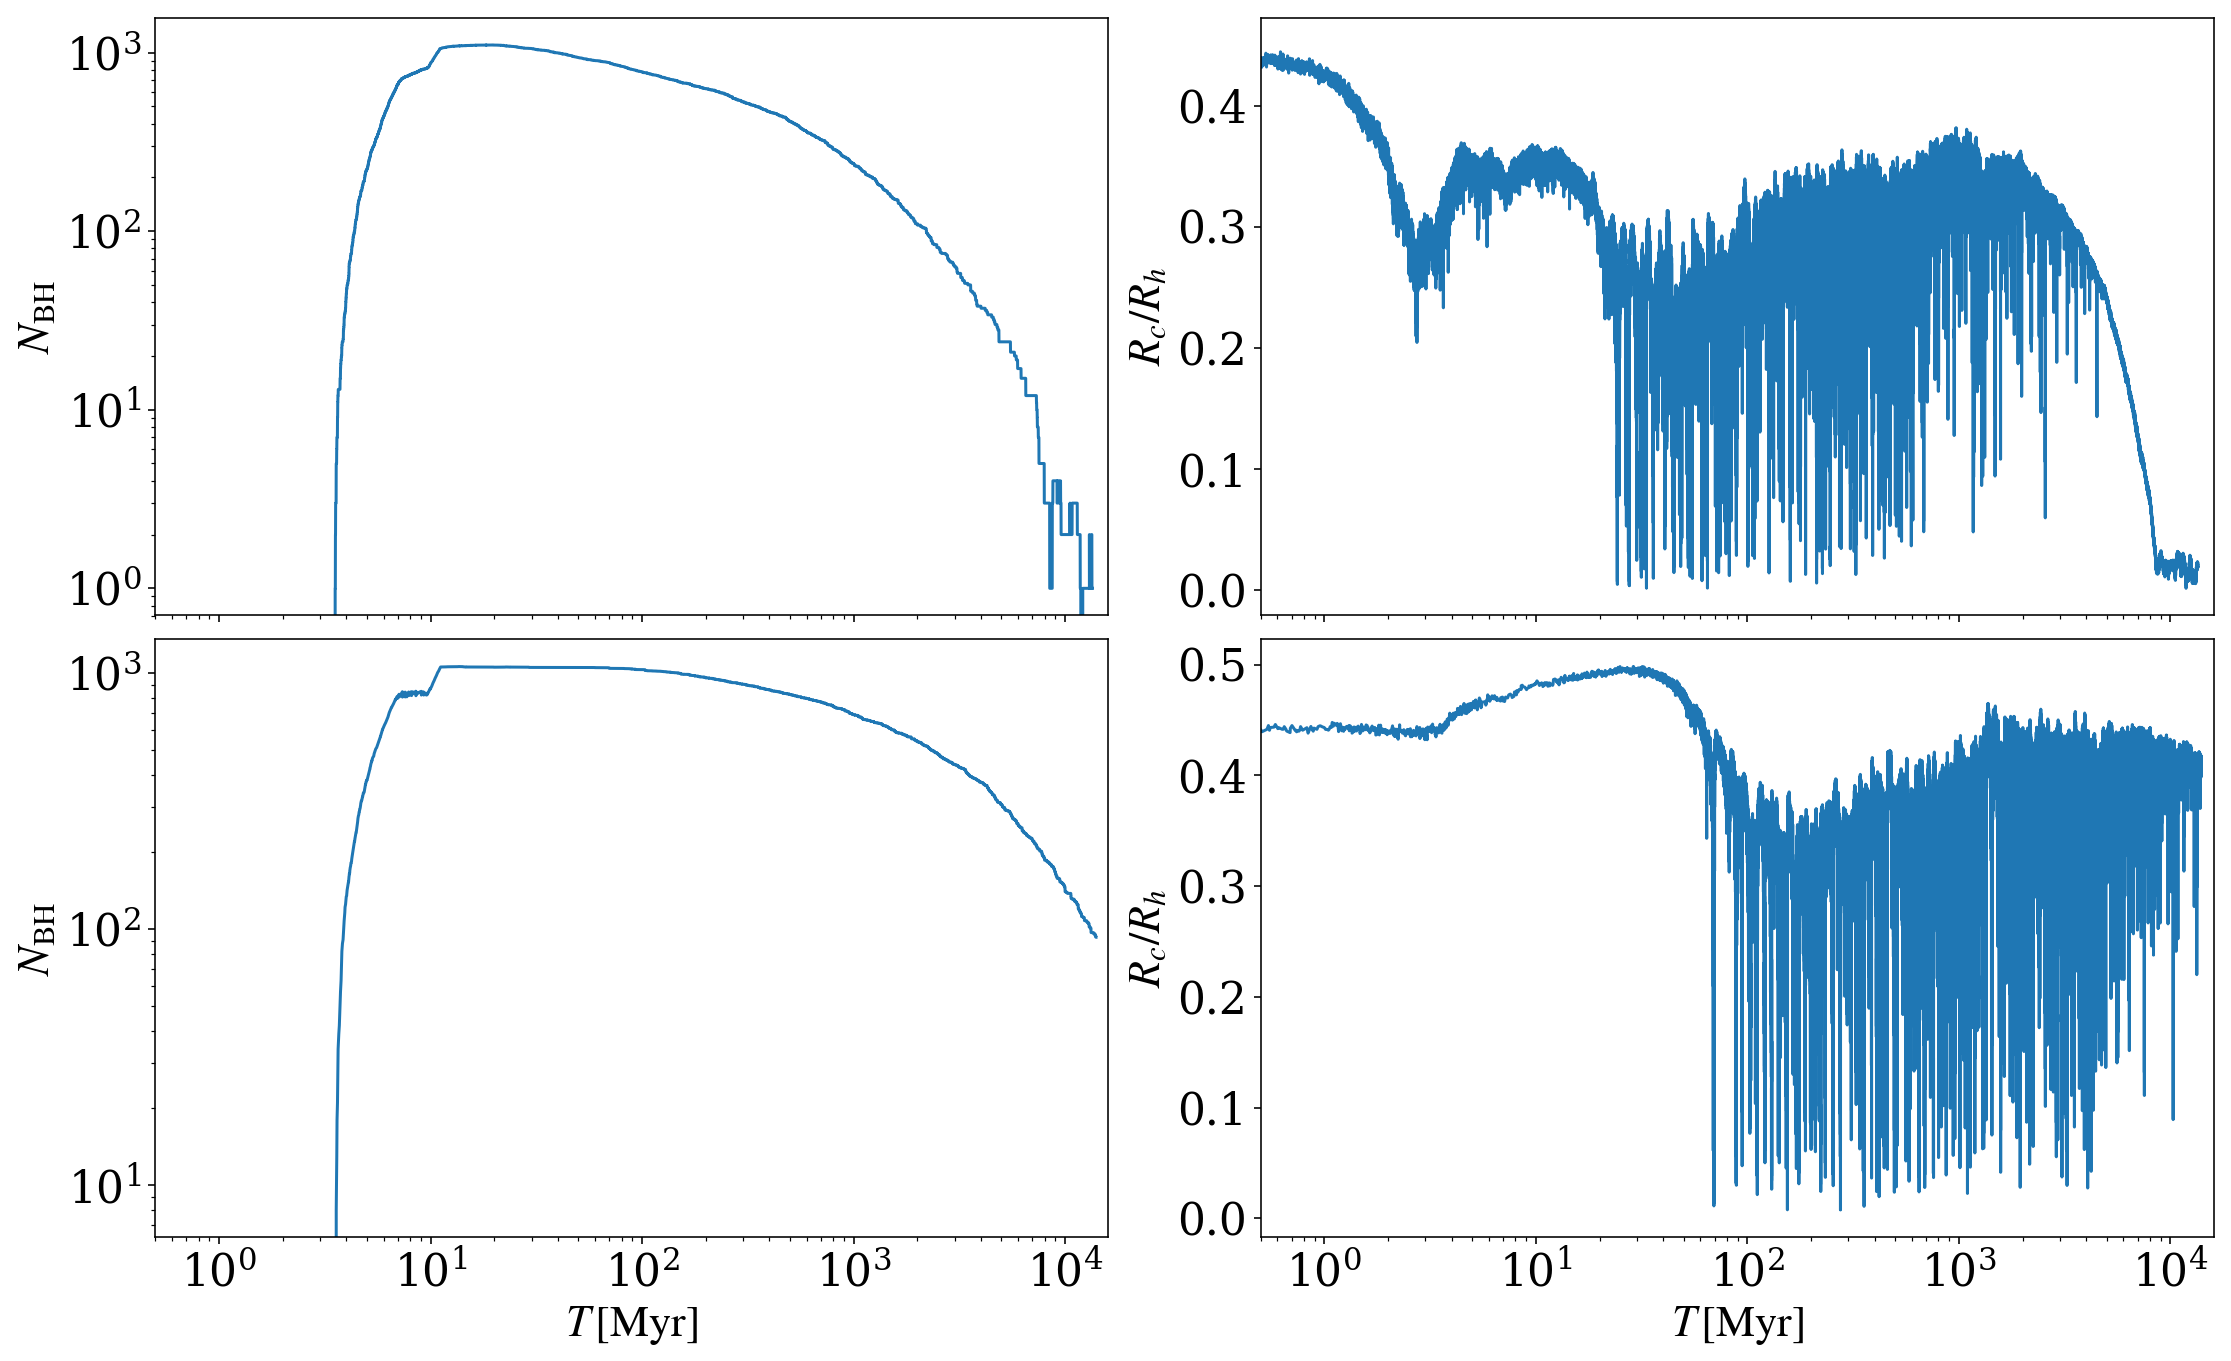

In [21]:
##Rc/Rh, Number of BHs and Cluster density as a function of time to check core-collapse
path2 = ['/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/',
         '/projects/b1091/CMC_Grid_March2019/rundir/rv2/rg8/z0.0002/8e5/']

fig, axs = plt.subplots(nrows = 2, ncols=2, figsize=(16, 10), sharex=True, sharey=False)
for xx in range(len(path2)):
    t_conv = dyn.conv('t', path2[xx]+'initial.conv.sh')
    l_conv = dyn.conv('l', path2[xx]+'initial.conv.sh')

    bhfile = np.genfromtxt(path2[xx]+'initial.bh.dat')
    tbh = bhfile[:,1]*t_conv; Nbh = bhfile[:,2]
    
    dynfile = np.genfromtxt(path2[xx]+'initial.dyn.dat')
    tdyn = dynfile[:,0]*t_conv; Rc = dynfile[:,7]*l_conv; Rh = dynfile[:,20]*l_conv
    Nc = dynfile[:,6]; rho_c = Nc/(2*twopi/3.)/Rc**3
    
    axs[xx][1].plot(tdyn, Rc/Rh)
    axs[xx][1].set_xscale('log')
    axs[xx][1].set_xlim(xmin=0.5, xmax=16000.)
    
    #axs[1].plot(tdyn, rho_c)
    #axs[1].set_yscale('log')
    #axs[1].set_xscale('log')
    #axs[1].set_ylabel(r'$\rho_c\,[\rm{pc^{-3}}]$')
    #axs[1].set_xlim(xmin=0.01, xmax=16000.)
    
    axs[xx][0].plot(tbh, Nbh)
    axs[xx][0].set_xscale('log')
    axs[xx][0].set_xlim(xmin=0.5, xmax=16000.)
    axs[xx][0].set_yscale('log')
    
    axs[xx][0].set_ylabel(r'$N_{\rm{BH}}$')
    axs[xx][1].set_ylabel(r'$R_c/R_h$')
    axs[1][xx].set_xlabel(r'$T\,[\rm{Myr}]$') 


fig.tight_layout()
plt.subplots_adjust(hspace=0.04, wspace=0.16)
plt.savefig(savepath+'nbh_rcrh.pdf', dpi=300)

280
141 ['104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '1851', '5272', '5272', '5904', '5904', '5904', '6121', '6205', '6205', '6205', '6205', '6205', '6205', '6266', '6266', '6266', '6266', '6266', '6266', '6342', '6397', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '6440', '6440', '6440', '6440', '6440', '6440', '6440', '6440', '6441', '6441', '6441', '6441', '6517', '6517', '6517', '6517', '6522', '6539', '6544', '6544', '6624', '6624', '6624', '6624', '6624', '6624', '6624', '6626', '6626', '6626', '6626', '6626', '6626', '6626', '6626', '6626', '6626', '6626', '6652', '6656', '6656', '6752', '6752', '6752', '6752', '6752', '6752', '6760', '6760', '6838', '7078', '7078', '7078', '7078', '7078', '7078', '7078', '7078', '7099', '7099

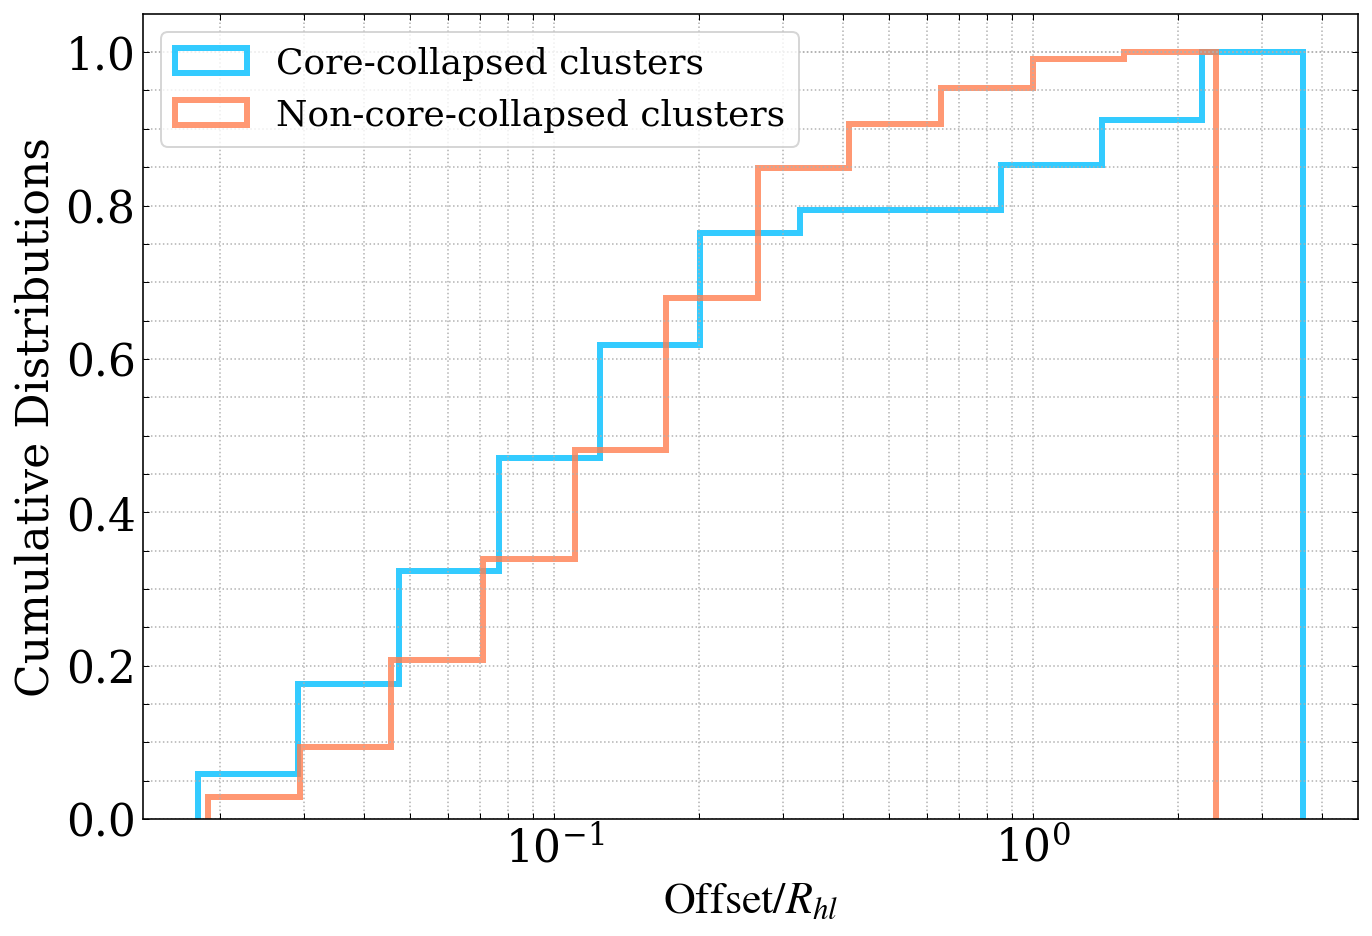

In [2]:
####Offset Distributions
Poff, Offset, Binoff, Nameoff, Clusoff = pc.readdata_freire(spinflag=0,offsetflag=1)
print(len(Clusoff), Clusoff)
print(np.max(Offset))
Offset=np.array(Offset); Binoff = np.array(Binoff)
Poff = np.array(Poff); Clusoff = np.array(Clusoff)
#Offset = Offset[Poff<=30.]; Binoff = Binoff[Poff<=30]; Clusoff = Clusoff[Poff<=30]
print(Offset, Clusoff)

data_gcmsp = pd.read_excel('/projects/b1095/syr904/projects/isolated_MSP/psrcatalog_numbers.xlsx',
                           names = ['name','rc','rhl','long','lat','dist','ntot','nbin','cc'],
                          skiprows = 1)
rc_psrcat = np.array(data_gcmsp['rc']); rhl_psrcat = np.array(data_gcmsp['rhl'])
print(len(rc_psrcat))
CCst = np.array(data_gcmsp['cc'])
print(CCst)
clusname = data_gcmsp['name']
clusno = []
for ii in range(len(clusname)):
    if str(clusname[ii])[0]=='N' or str(clusname[ii])[0]=='T':
        clusno.append(str(clusname[ii]).split()[-1])
    else:
        clusno.append(re.split('\)| ', str(clusname[ii]))[-2])
clusno = np.array(clusno)

Rcoff = []; Rhloff = []; CCs = []
for kk in range(len(Clusoff)):
    Rcoff.append(rc_psrcat[clusno==Clusoff[kk]][0])
    Rhloff.append(rhl_psrcat[clusno==Clusoff[kk]][0])
    CCs.append(CCst[clusno==Clusoff[kk]][0]) 
Rcoff = np.array(Rcoff); Rhloff = np.array(Rhloff)
CCs = np.array(CCs)
print(Rhloff, Clusoff)


ccoffrhl = (Offset/Rhloff)[CCs==1]
nonccoffrhl = (Offset/Rhloff)[CCs==0]
nobs_cc = len(ccoffrhl)
nobs_noncc = len(nonccoffrhl)
print(nobs_cc, nobs_noncc)

print(stats.ks_2samp(ccoffrhl, nonccoffrhl))
####Plotting
fig, ax = plt.subplots(figsize=(10,7))
ax.hist(ccoffrhl,# bins=10,
        bins = np.logspace(np.log10(np.min(ccoffrhl)), np.log10(np.max(ccoffrhl)), 12),
        cumulative=True, density=True,# stacked=True,
        #density=True,
        histtype='step', label = 'Core-collapsed clusters', lw=3, color='deepskyblue', alpha=0.8)
ax.hist(nonccoffrhl,# bins=10,
        bins = np.logspace(np.log10(np.min(nonccoffrhl)), np.log10(np.max(nonccoffrhl)), 12),
        cumulative=True, density=True,# stacked=True,
        #density=True,
        histtype='step', label = 'Non-core-collapsed clusters', lw=3, color='coral', alpha=0.8)


ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(r'$\rm{Offset}/\mathit{R_{hl}}$')
ax.set_ylabel('Cumulative Distributions')
ax.legend(loc='upper left', fontsize=18)
plt.grid(linestyle=':',which='major',linewidth='0.75')
plt.grid(linestyle=':',which='minor',linewidth='0.75')
plt.gca().xaxis.set_ticks_position('both')
plt.gca().yaxis.set_ticks_position('both')
plt.tick_params('both',length=3,width=0.5,which='both',direction = 'in')

fig.tight_layout()
plt.savefig(savepath+'observed_offset_cc_noncc.pdf', dpi=300)

[0.00000000e+00 1.00010001e+00 2.00020002e+00 ... 9.99799980e+03
 9.99899990e+03 1.00000000e+04]
[0.         0.01206161 0.02309613 ... 3.99760124 3.99780137 3.9980015 ]
[ 0.          8.11246222 14.87273472 ... 89.13981428 89.13982319
 89.13983209]


/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in log10
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:36: RuntimeWarning: divide by zero encountered in log10
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in log10
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:40: RuntimeWarning: divide by zero encountered in log10
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in log10
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in log10


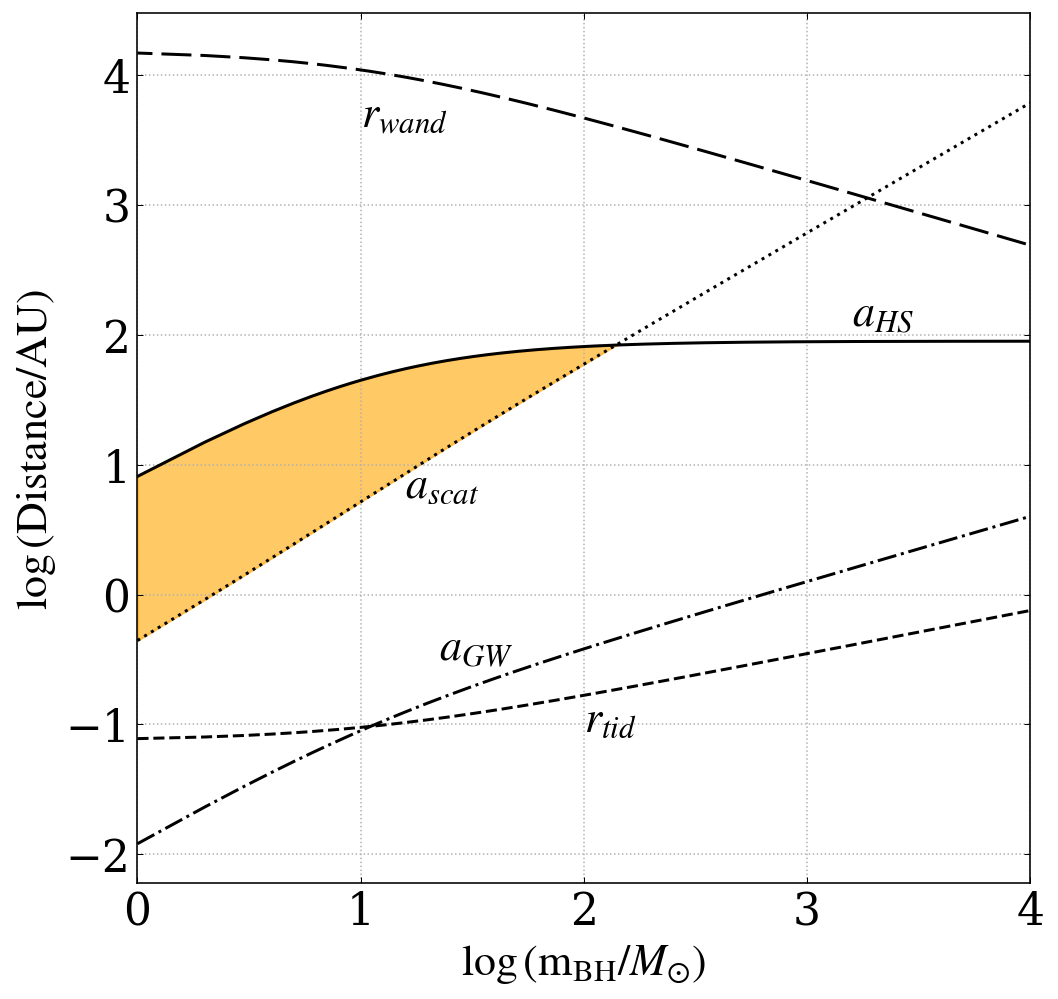

In [8]:
##Remaking Figure 1 in the paper
M_bh1=10.0
m_bh2=np.linspace(0,10000.0,num=10000)
print(m_bh2)
mu_bh=M_bh1*m_bh2/(M_bh1+m_bh2)
M_bht=M_bh1+m_bh2
tau_gw=10.0**10.0
ma=2.5
mb=0.5


# All in AU:
a_gw=0.4*(M_bht/100.0)**0.5*(mu_bh/10.0)*(tau_gw/(10.0**10.0))
print(a_gw)

#This is from Merritt (2013) for a single IMBH, but is valid to within a factor of two for a binary IMBH-BH as well:
a_wand=0.03*(M_bht/10.0**3.0)**(-0.5)*(5.0/20.0)/(4.8481*10.0**(-6.0))
v_ej=35.0
a_scat=mu_bh/10.0*(35.0/v_ej)
r_tid=0.2*(M_bht/100.0*1.6/(ma+mb))**(1.0/3.0)
G=6.678*10.0**(-11.0)
Es=0.5*(M_bh1+m_bh2)*(ma+mb)/(M_bh1+m_bh2+mb+ma)*(5000.0)**2.0
#	-G*ma*mb/(2.0*a)
a_rec=G*(M_bh1*m_bh2)*(1.9989*10.0**30.0)**1.0/(-2.0*Es+35000.0**2.0*(2.0**2.0*(M_bh1+m_bh2)*(ma+mb)/(M_bh1+m_bh2-ma-mb)))
a_rec=a_rec/(1.496*10.0**11.0)


mbh_imbh=np.linspace(0,10000.0,num=10000)
#G=6.678*10.0**(-11.0)
rm=G*(mbh_imbh*1.9989*10.0**30.0)/(5.0*1000.0)**2.0
a_hs=10.0/(mbh_imbh+10.0)*rm/4.0
a_hs=a_hs/(1.496*10.0**11.0)
print(a_hs)

log_a_gw=np.log10(a_gw)
log_a_scat=np.log10(a_scat)
log_r_tid=np.log10(r_tid)
log_a_wand=np.log10(a_wand)
log_ahs=np.log10(a_hs)
log_arec=np.log10(a_rec)


log_mbh2=np.log10(m_bh2)
log_mbh_imbh=np.log10(mbh_imbh)

fig, axs = plt.subplots(figsize=(8,8))
axs.plot(log_mbh_imbh, log_ahs, c='k')
axs.text(3.2, 2.07, '$a_{HS}$')
axs.plot(log_mbh2, log_a_wand, ls=(5,(10,3)), c='k')
axs.text(1,3.6, '$r_{wand}$')
axs.plot(log_mbh2, log_a_gw, ls='dashdot', c='k')
axs.text(1.35, -0.5, '$a_{GW}$')
axs.plot(log_mbh2, log_arec, ls='dotted', c='k')
axs.text(1.2, 0.75, '$a_{scat}$')
axs.plot(log_mbh2, log_r_tid, ls='--', c='k')
axs.text(2.0, -1.05, '$r_{tid}$')
axs.fill_between(log_mbh2[log_mbh2<=2.15], log_arec[log_mbh2<=2.15], log_ahs[log_mbh2<=2.15], 
                alpha=0.6, color='orange')


axs.set_xlim(xmin=0, xmax=4)
axs.set_xlabel(r'$\rm{log}\,(m_{\rm{BH}}/\mathit{M_{\odot}})$')
axs.set_ylabel(r'$\rm{log\,(Distance/AU)}$')
plt.grid(linestyle=':',which='major',linewidth='0.75')
plt.grid(linestyle=':',which='minor',linewidth='0.75')
plt.gca().xaxis.set_ticks_position('both')
plt.gca().yaxis.set_ticks_position('both')
plt.tick_params('both',length=3,width=0.5,which='both',direction = 'in')

plt.savefig(savepath+'remake_figure1.pdf', dpi=300)


#       	expand 1.05
#	limits 0 4.0 -2.5 4.5
##      	limits 0 4.0 -2 4
#       	box
#       	ltype 0
#	lweight 5
#	ltype 5
#     	connect log_mbh2 log_a_gw
#       	ltype 1
##       	connect log_mbh2 log_a_scat
#	connect log_mbh2 log_arec
#	ltype 2
#       	connect log_mbh2 log_r_tid
#	ltype 3
#	connect log_mbh2 log_a_wand
#	ltype 0
#	connect log_mbh_imbh log_ahs
#	ctype default


#lweight 2.5
#relocate 1.35 -0.5
#label a_{GW}
#relocate 1.2 0.83
#label a_{scat}
#relocate 2.0 -1.05
#label r_{tid}
#relocate 1 3.7
#label r_{wand}
#relocate 3.2 2.07
#label a_{HS}

#lweight 1
#ltype 0
#   	expand 1.5
#   	xlabel log (m_{BH}/M_{\odot})
#   	ylabel log (Distance/AU)

#ltype 0
       